In [3]:
import numpy as np

class Node:
  def __init__(self, parent, pos, index, path_distance = 0.0):
    self.parent = parent
    self.pos = pos
    self.index = index
    self.children = []
    self.path_distance = path_distance

    if parent is not None:
      parent.children.append(self)

def mstree(points, balancing_factor = 0.5):
  length = len(points)
  dimensions = len(points[0])

  closed_list = {}

  root_point = points[0]

  root_node = Node(None, root_point, 0)
  closed_list[0] = root_node

  # Init open points list
  open_list = [x for x in range(1,length)]

  # Init distance to root_point
  distances_squared = np.sum(np.square(points - root_point), axis = 1)
  distances = np.empty(length)
  for i in range(length - 1):
    distances[i] = np.sqrt(distances_squared[i])

  closest_point_in_tree = np.zeros(length, dtype = int)
  
  distances = np.sqrt(distances_squared)

  open_distance_list = distances.copy()[1:]
  
  while len(open_distance_list) > 0:
    minimum_index = np.argmin(open_distance_list)
    minimum = open_distance_list[minimum_index]
    point_index = open_list.pop(minimum_index)

    # Get closest point and append new node to it
    closest_point_index = closest_point_in_tree[point_index]

    location = points[point_index]

    parent_node = closed_list[closest_point_index]
    actual_distance = np.sqrt(np.sum(np.square(location - parent_node.pos)))
    path_distance = actual_distance + parent_node.path_distance
    node = Node(parent_node, location, point_index, path_distance)
    
    # Add to closed list
    closed_list[point_index] = node
    # Remove from open list
    open_distance_list = np.delete(open_distance_list, minimum_index)

    open_points = points[open_list]
    weighted_distance = np.sqrt(np.sum(np.square(np.subtract(open_points, location)), axis = 1)) + balancing_factor * path_distance
    open_distance_list_indeces = np.argmin(np.column_stack((open_distance_list, weighted_distance)), axis = 1)
    open_distance_list = np.minimum(open_distance_list, weighted_distance)
    changed_values = np.zeros(len(closest_point_in_tree), dtype = bool)
    changed_values.put(open_list, open_distance_list_indeces)
    closest_point_in_tree = np.where(changed_values == 1, point_index, closest_point_in_tree)

  return root_node

def tree_to_list(root_node):
  """Orders the nodes into a list recursivly using depth-first-search"""
  ls = [root_node]
  for child in root_node.children:
    ls.extend(tree_to_list(child))
  return ls


def build_tree_mesh(root_node, skin = False):
    nodes = tree_to_list(root_node)

    vertices = [node.pos for node in nodes]

    edges = []
    for i, node in enumerate(nodes):
        if node.parent is not None:
            edges.append([i, nodes.index(node.parent)])

    # mesh = bpy.data.meshes.new("Tree")
    # mesh.from_pydata(vertices, edges, [])
    # mesh.update()

    # obj = bpy.data.objects.new("Tree", mesh)
    # bpy.context.scene.collection.objects.link(obj)

    # if skin:
    #     obj.modifiers.new("DendriteThickness", 'SKIN')
    #     obj.modifiers["DendriteThickness"].use_smooth_shade = True
    #     for i, node in enumerate(nodes):
    #         obj.data.skin_vertices[0].data[i].radius= (node.thickness * 0.005, node.thickness * 0.005)

    return (vertices, edges)

def write_cpp_input_file(filename, vertices, edges):
    # TODO
    singularities = (vertices[edges[:, 0]] + vertices[edges[:, 1]]) / 2
    singularities = np.c_[singularities, edges]
    np.savetxt(filename, singularities)


def write_vtk(filename, vertices, edges, dict = {}):
    """ Write a VTK file """
    f = open(filename, "w")

    f.write("# vtk DataFile Version 3.0\n")
    f.write("Fibers output - vtk\n")
    f.write("ASCII\n")
    f.write("DATASET UNSTRUCTURED_GRID\n")
    f.write("POINTS " + str(len(vertices)) + " DOUBLE\n")

    for v in vertices:
        f.write(str(v[0]) + " " + str(v[1]) + " " + str(v[2]) + "\n")

    f.write("CELLS " + str(len(edges)) + " " + str(3 * len(edges)) + "\n")
    for e in edges:
        f.write("2 " + str(int(e[0])) + " " + str(int(e[1])) + "\n")

    f.write("CELL_TYPES " + str(len(edges)) + "\n")
    for e in edges:
        f.write("3\n")
    
    # Check if we have point or cell data
    for key, data in dict.items():
      print("CIAO")
      if len(data) == len(vertices):
        f.write("POINT_DATA " + str(len(data)) + "\n")
      elif len(data) == len(edges):
        f.write("CELL_DATA " + str(len(data)) + "\n")
      else:
        return 
      f.write("SCALARS " + key + " float \n")
      f.write("LOOKUP_TABLE default \n")
      for l in data:
          f.write(str(l) + "\n")
      
    f.close()

In [4]:
points = np.random.rand(10, 3)

In [5]:
tree = mstree(points, 0.1)
(vertices, edges) = build_tree_mesh(tree)
path_distance = [node.path_distance for node in tree_to_list(tree)]
edge_length= np.array([np.linalg.norm(vertices[int(e[0])] - vertices[int(e[1])]) for e in edges])
write_vtk("/Users/heltai/c++/reduced_lagrange_multipliers/data/tests/mstree_10.vtk", vertices, edges, {"path_distance": path_distance, "edge_length": edge_length})

CIAO
CIAO


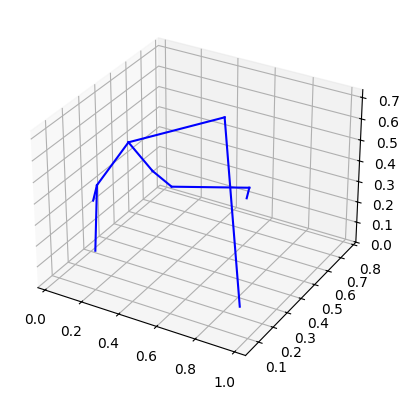

In [6]:
# Plot the tree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for edge in edges:
    ax.plot([vertices[edge[0]][0], vertices[edge[1]][0]], [vertices[edge[0]][1], vertices[edge[1]][1]], [vertices[edge[0]][2], vertices[edge[1]][2]], 'b')

plt.show()